In [7]:
import csv

def find_max_row_index(filename, column_index):
    # 读取CSV文件
    data = []
    with open(filename, 'r') as csvfile:
        csvreader = csv.reader(csvfile)
        for row in csvreader:
            data.append(row)

    # 寻找指定列最大值的索引
    max_value = float('-inf')
    max_value_index = -1
    for i, row in enumerate(data):
        if i <= 2:  # 跳过表头
            continue
        value = float(row[column_index])
        if value >= max_value:
            max_value = value
            max_value_index = i
    
    if max_value_index!=-1:
        print('第',data[max_value_index][0],'轮，Acc为',max_value)
    else:
        print("没有找到最大值")

    return max_value_index

In [8]:
filename = '/data/hjy/SSF/vit_base_patch16_224_in21k/vtab/patch_camelyon/ssf/20230812-210719-vit_base_patch16_224_in21k-224/summary.csv'
column_index = 3  # 第五列的索引（从0开始）
max_row_index = find_max_row_index(filename, column_index)

第 155 轮，Acc为 86.627197265625


## 稀疏率

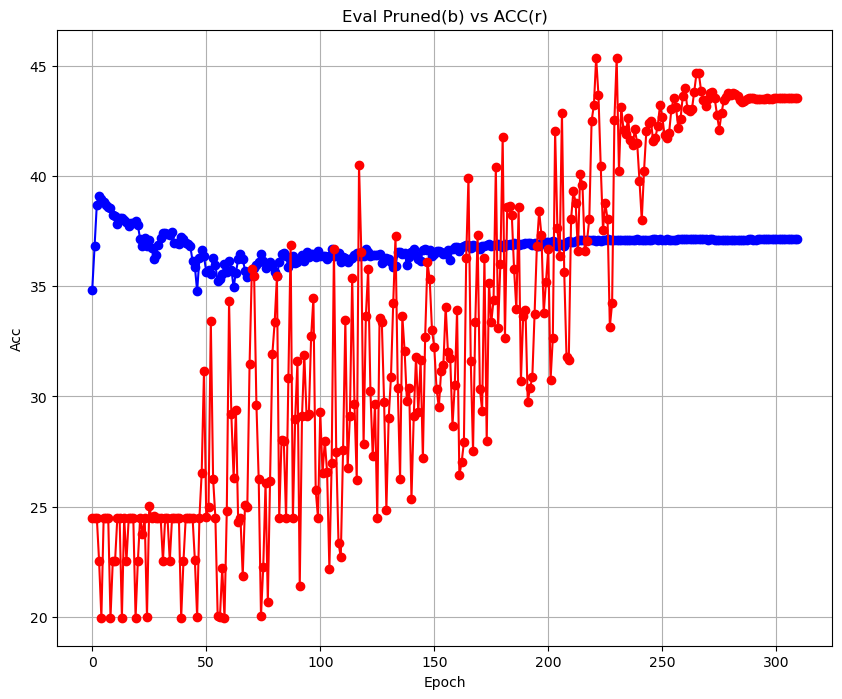

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# 从CSV文件读取数据
data = pd.read_csv('/data/hjy/SSF/vit_base_patch16_224_in21k/vtab/clevr_dist/pruning_retrain_full/20230813-194328-vit_base_patch16_224_in21k-224/summary.csv')
S=0
E=None
# 提取数据列
epochs = data['epoch']
acc1 = data['eval_top1']
eval_pruned = data['eval_pruned']
eval=[x*100 for x in eval_pruned]
epochs=epochs[S:E]
eval=eval[S:E]
acc1=acc1[S:E]


# 创建折线图
plt.figure(figsize=(10, 8))
plt.plot(epochs, eval, marker='o', linestyle='-', color='b')
plt.plot(epochs, acc1, marker='o', linestyle='-', color='r')

# 添加标题和标签
plt.title('Eval Pruned(b) vs ACC(r)')
plt.xlabel('Epoch')
plt.ylabel('Eval Pruned %')
plt.ylabel('Acc')

# 显示图形
plt.grid(True)
plt.show()


## 准确率

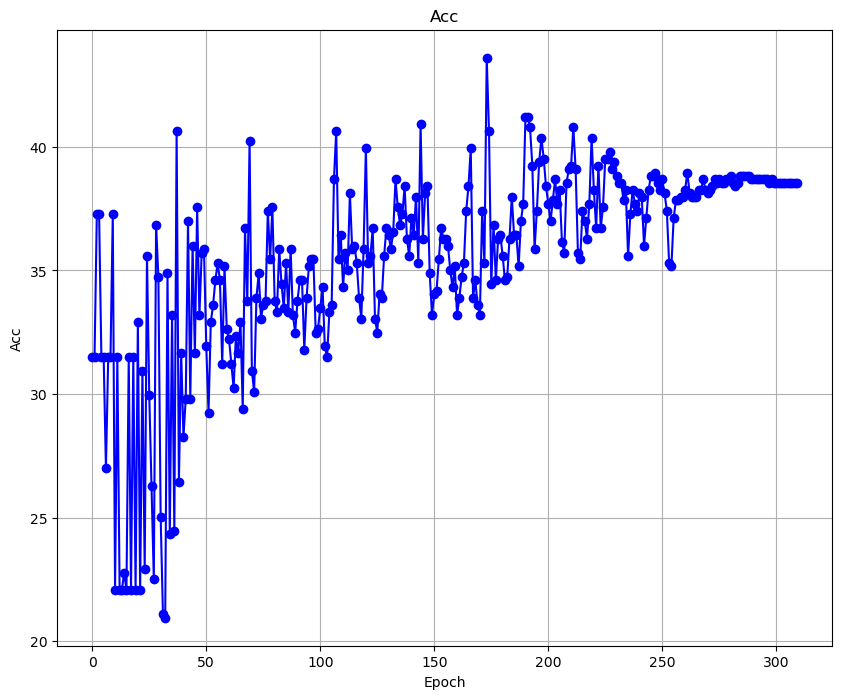

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
e3_3="/data/hjy/SSF/vit_base_patch16_224_in21k/vtab/kitti/pruning_retrain_full/20230814-053539-vit_base_patch16_224_in21k-224/summary.csv"
e1_4="/data/hjy/SSF/vit_base_patch16_224_in21k/vtab/kitti/pruning_retrain_full/20230814-072738-vit_base_patch16_224_in21k-224/summary.csv"
# 从CSV文件读取数据
data = pd.read_csv(e1_4)
S=0
E=None
# 提取数据列
epochs = data['epoch']
# eval_pruned = data['eval_pruned']
# eval=[x*100 for x in eval_pruned]
acc1 = data['eval_top1']
epochs=epochs[S:E]
acc1=acc1[S:E]


# 创建折线图
plt.figure(figsize=(10, 8))
plt.plot(epochs, acc1, marker='o', linestyle='-', color='b')

# 添加标题和标签
plt.title('Acc')
plt.xlabel('Epoch')
plt.ylabel('Acc')

# 显示图形
plt.grid(True)
plt.show()


In [1]:
%cd ..
!pwd

/home/xmu/hjy/SSF
/home/xmu/hjy/SSF


In [2]:

import torch
import timm
from timm.models import create_model, safe_model_name, resume_checkpoint, load_checkpoint,\
    convert_splitbn_model, model_parameters
from models import vision_transformer, swin_transformer, convnext, as_mlp


/home/xmu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
MODEL_NAME="vit_base_patch16_224_in21k"
MODEL_PATH="/data/hjy/SSF/vit_base_patch16_224_in21k/vtab/smallnorb_ele/baseline-36.88-94.pth.tar"
# MODEL_PATH="/data/hjy/SSF/vit_base_patch16_224_in21k/vtab/smallnorb_ele/ele_11.14_221_0.1_0.01.pth.tar"
# MODEL_PATH="/data/hjy/SSF/vit_base_patch16_224_in21k/vtab/smallnorb_ele/pruning_retrain_full/20230812-104200-vit_base_patch16_224_in21k-224/model_best.pth.tar"
MODEL_PATH="/data/hjy/SSF/vit_base_patch16_224_in21k/vtab/diabetic_retinopathy/baseline-75.84-21.pth.tar"
# MODEL_PATH="/data/hjy/SSF/vit_base_patch16_224_in21k/vtab/diabetic_retinopathy/rec=0.7_73.60_37.pth.tar"
# MODEL_PATH="/data/hjy/SSF/vit_base_patch16_224_in21k/vtab/diabetic_retinopathy/full-73.60.pth.tar"
METHOD_NAME="ssf"
NUM_CLASSES=5

In [26]:
model = create_model(
    MODEL_NAME,
    pretrained=True,
    num_classes=NUM_CLASSES,
    drop_rate=0.0,
    drop_path_rate=0.0,
    drop_block_rate=None,
    global_pool=None,
    bn_momentum=None,
    bn_eps=None,
    scriptable=False,
    checkpoint_path='',
    tuning_mode=METHOD_NAME)
resume_epoch = resume_checkpoint(
    model, MODEL_PATH,
    optimizer=None,
    loss_scaler=None,
    log_info=True)


In [27]:
total=0
pruned=0
t=p=t1=p1=t2=p2=0
for name, param in model.named_parameters():
        if 'ssf_scale' in name :
            t1 += param.numel()
            p1 += (torch.abs(param.data) < 0.01).sum().item()
        if 'ssf_shift' in name:
            t2 += param.numel()
            p2 += (torch.abs(param.data) < 0.01).sum().item()
        if 'ssf_scale' in name or 'ssf_shift' in name:
            t += param.numel()
            p += (torch.abs(param.data) < 0.01).sum().item()
print(p1/t1)
print(p2/t2)
print(p/t)
print(t)

0.0
0.21905122823383086
0.10952561411691543
205824
